# Food Inspection Results Prediction
# Advanced Topics in Machine Learning – Final Project

# 1. Imports and Configuration


In [1]:
### CODE BY GPT ###

# Data handling
import numpy as np
import pandas as pd
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap



import warnings
warnings.filterwarnings("ignore")

In [2]:
### CODE BY GPT ###

RANDOM_STATE = 42

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Food Inspection Results Prediction
# Advanced Topics in Machine Learning – Final Project

# 2.Dataset Loading


In [3]:
### CODE BY GPT ###

# Socrata API endpoint (CSV format)
BASE_URL = "https://data.cityofchicago.org/resource/4ijn-s7e5.csv"

# Number of rows used in the project
N_ROWS = 300_554

# Deterministic ordering to ensure reproducibility
ORDER_BY = "inspection_date DESC, inspection_id DESC"

DATA_PATH = (
    f"{BASE_URL}"
    f"?$limit={N_ROWS}"
    f"&$order={ORDER_BY.replace(' ', '%20')}"
)

# Load dataset
df = pd.read_csv(DATA_PATH, encoding="latin1")

# ---- Rename columns to match your OLD notebook names (so no fixes later) ----
rename_map = {
    "inspection_id": "Inspection ID",
    "dba_name": "DBA Name",
    "aka_name": "AKA Name",
    "license_": "License #",
    "facility_type": "Facility Type",
    "risk": "Risk",
    "address": "Address",
    "city": "City",
    "state": "State",
    "zip": "Zip",
    "inspection_date": "Inspection Date",
    "inspection_type": "Inspection Type",
    "results": "Results",
    "violations": "Violations",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "location": "Location"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Basic inspection
print("Dataset shape:", df.shape)
display(df.head())

print("\nColumn info:")
df.info()


Dataset shape: (300554, 17)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2629233,THE L STATION,THE L STATION,2863297.0,Restaurant,Risk 1 (High),186 N WELLS ST,CHICAGO,IL,60606.0,2026-01-02T00:00:00.000,Canvass,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.885454,-87.634069,"\n, \n(41.88545388445344, -87.63406900086157)"
1,2629231,SMOOTHIE SHOP,SMOOTHIE SHOP,2845318.0,Restaurant,Risk 2 (Medium),5858 W GRAND AVE,CHICAGO,IL,60639.0,2025-12-31T00:00:00.000,Canvass,Out of Business,NaN,41.920189,-87.772978,"\n, \n(41.92018907108374, -87.77297844495868)"
2,2629230,JUST PIZZA EXPRESS INC.,JUST PIZZA EXPRESS INC,2575486.0,Restaurant,Risk 2 (Medium),4349 W FULLERTON AVE,CHICAGO,IL,60639.0,2025-12-31T00:00:00.000,Canvass,Out of Business,NaN,41.924261,-87.736111,"\n, \n(41.92426074629291, -87.73611087868458)"
3,2629229,"LA CANASTA BAKERY, INC.",LA CANASTA BAKERY,1875426.0,Bakery,Risk 1 (High),3575 W ARMITAGE AVE,CHICAGO,IL,60647.0,2025-12-31T00:00:00.000,Canvass Re-Inspection,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.917176,-87.716470,"\n, \n(41.91717626374163, -87.71647045109401)"
4,2629228,LA MINERVHA,LA MINERVHA,3035911.0,NaN,Risk 3 (Low),1401 W 18TH ST,CHICAGO,IL,60608.0,2025-12-31T00:00:00.000,License,Not Ready,NaN,41.857765,-87.661385,"\n, \n(41.85776469124289, -87.66138509368912)"



Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300554 entries, 0 to 300553
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    300554 non-null  int64  
 1   DBA Name         300554 non-null  object 
 2   AKA Name         298185 non-null  object 
 3   License #        300536 non-null  float64
 4   Facility Type    295392 non-null  object 
 5   Risk             300469 non-null  object 
 6   Address          300554 non-null  object 
 7   City             300386 non-null  object 
 8   State            300488 non-null  object 
 9   Zip              300514 non-null  float64
 10  Inspection Date  300554 non-null  object 
 11  Inspection Type  300553 non-null  object 
 12  Results          300554 non-null  object 
 13  Violations       216497 non-null  object 
 14  Latitude         299530 non-null  float64
 15  Longitude        299530 non-null  float64
 16  Location         299530 

# 3. Target Variable Definition


In [4]:
### CODE BY GPT ###

display(df["Results"].value_counts(dropna=False).to_frame("count"))

df = df[df["Results"].isin(["Pass", "Fail"])].copy()
df["target_fail"] = (df["Results"] == "Fail").astype(int)

print("Shape after filtering Pass/Fail:", df.shape)
display(df["Results"].value_counts().to_frame("count"))
display(df["target_fail"].value_counts().to_frame("count"))

print("target_fail exists?", "target_fail" in df.columns)

,count
Results,
Pass,155082
Fail,57863
Pass w/ Conditions,44959
Out of Business,25084
No Entry,13269
Not Ready,4203
Business Not Located,94


Shape after filtering Pass/Fail: (212945, 18)


,count
Results,
Pass,155082
Fail,57863


,count
target_fail,
0,155082
1,57863


target_fail exists? True


# 4. Data Preprocessing
# 4.1 Feature Selection


In [5]:
### CODE BY GPT ###

selected_features = [
    "Facility Type",
    "Risk",
    "Inspection Type",
    "Inspection Date",
    "Latitude",
    "Longitude"
]

df_model = df[selected_features + ["target_fail"]].copy()

df_model.head(), df_model.shape

(  Facility Type           Risk          Inspection Type          Inspection Date   Latitude  Longitude  target_fail
 0    Restaurant  Risk 1 (High)                  Canvass  2026-01-02T00:00:00.000  41.885454 -87.634069            0
 3        Bakery  Risk 1 (High)    Canvass Re-Inspection  2025-12-31T00:00:00.000  41.917176 -87.716470            0
 6    Restaurant  Risk 1 (High)                  Canvass  2025-12-31T00:00:00.000  41.945050 -87.654953            0
 7    Restaurant  Risk 1 (High)  Complaint Re-Inspection  2025-12-31T00:00:00.000  41.931371 -87.711418            0
 9    Restaurant  Risk 1 (High)    Canvass Re-Inspection  2025-12-31T00:00:00.000  41.880757 -87.634709            0,
 (212945, 7))

<div dir="rtl">

### המאפיינים שנבחרו מייצגים גורמים מרכזיים אשר עשויים להשפיע על תוצאות ביקורת תברואה.
### סוג המוסד (Facility Type) משקף הבדלים בסטנדרטים תפעוליים בין עסקים שונים, בעוד שרמת הסיכון (Risk) מהווה אינדיקציה ישירה לפוטנציאל ליקויים תברואתיים.
### סוג הביקורת (Inspection Type) מבדיל בין ביקורות שגרתיות לביקורות בעקבות תלונה.
### תאריך הביקורת מאפשר זיהוי דפוסים זמניים, ואילו המאפיינים הגיאוגרפיים (Latitude, Longitude) מאפשרים זיהוי מגמות מרחביות הקשורות לתוצאות הביקורת.

</div>

# 4.2 Handling Missing Values

In [6]:
### CODE BY GPT ###

missing_counts = df_model.isnull().sum()
missing_percent = (missing_counts / len(df_model)) * 100

missing_summary = (
    pd.DataFrame({
        "Missing Count": missing_counts,
        "Missing Percent": missing_percent
    })
    .sort_values("Missing Count", ascending=False)
)

missing_summary

,Missing Count,Missing Percent
Latitude,815,0.382728
Longitude,815,0.382728
Facility Type,574,0.269553
Risk,35,0.016436
Inspection Type,1,0.000470
Inspection Date,0,0.000000
target_fail,0,0.000000


In [7]:
### CODE BY GPT ###

categorical_cols = ["Facility Type", "Risk", "Inspection Type"]
for col in categorical_cols:
    df_model[col] = df_model[col].fillna(df_model[col].mode()[0])

numeric_cols = ["Latitude", "Longitude"]
for col in numeric_cols:
    df_model[col] = df_model[col].fillna(df_model[col].median())

In [8]:
### CODE BY GPT ###

df_model.isnull().sum()

Facility Type      0
Risk               0
Inspection Type    0
Inspection Date    0
Latitude           0
Longitude          0
target_fail        0
dtype: int64

<div dir="rtl">

### הערכים החסרים הושלמו באמצעות שיטות המתאימות לסוג המאפיין. 
### מאפיינים קטגוריאליים הושלמו בערך השכיח, ומאפיינים מספריים הושלמו באמצעות החציון, על מנת לשמר את מבנה הנתונים ולמנוע השפעת חריגים.

</div>


# 4.3 Date Processing

In [9]:
### CODE BY GPT ###

df_model["Inspection Date"] = pd.to_datetime(df_model["Inspection Date"])

In [10]:
### CODE BY GPT ###

df_model["Inspection_Year"] = df_model["Inspection Date"].dt.year
df_model["Inspection_Month"] = df_model["Inspection Date"].dt.month
df_model["Inspection_Day"] = df_model["Inspection Date"].dt.day
df_model["Inspection_Weekday"] = df_model["Inspection Date"].dt.weekday

In [11]:
### CODE BY GPT ###

df_model = df_model.drop(columns=["Inspection Date"])

In [12]:
### CODE BY GPT ###

df_model.head(), df_model.shape

(  Facility Type           Risk          Inspection Type   Latitude  Longitude  target_fail  Inspection_Year  Inspection_Month  \
 0    Restaurant  Risk 1 (High)                  Canvass  41.885454 -87.634069            0             2026                 1   
 3        Bakery  Risk 1 (High)    Canvass Re-Inspection  41.917176 -87.716470            0             2025                12   
 6    Restaurant  Risk 1 (High)                  Canvass  41.945050 -87.654953            0             2025                12   
 7    Restaurant  Risk 1 (High)  Complaint Re-Inspection  41.931371 -87.711418            0             2025                12   
 9    Restaurant  Risk 1 (High)    Canvass Re-Inspection  41.880757 -87.634709            0             2025                12   
 
    Inspection_Day  Inspection_Weekday  
 0               2                   4  
 3              31                   2  
 6              31                   2  
 7              31                   2  
 9           

<div dir="rtl">

### עמודת תאריך הביקורת הומרה לפורמט זמן ופוצלה למאפייני זמן נפרדים.
### פיצול זה מאפשר למודל ללמוד דפוסים עונתיים ומגמות לאורך זמן, בהתאם להגדרות שנקבעו בחלק התיאורטי של הפרויקט.

</div>


# Violation-Based Feature Engineering

In [13]:
### CODE BY GPT ###

if "Violations" not in df_model.columns:
    if "df" in globals() and "Violations" in df.columns:
        df_model["Violations"] = df.loc[df_model.index, "Violations"]
    else:
        raise ValueError(
            "Violations column is missing in df_model, and I couldn't find a global 'df' with a 'Violations' column. "
            "Make sure you still have the original dataframe loaded as 'df'."
        )


viol_text = df_model["Violations"].fillna("").astype(str)

df_model["violations_count"] = viol_text.apply(lambda s: len(re.findall(r"\b\d+\.", s)))

fallback_mask = (df_model["violations_count"] == 0) & (viol_text.str.contains(r"\||\n", regex=True))
df_model.loc[fallback_mask, "violations_count"] = (
    viol_text[fallback_mask]
    .str.split(r"\||\n", regex=True)
    .apply(lambda parts: sum(1 for p in parts if p.strip()))
)

critical_keywords = [
    "rodent", "rats", "mice",
    "sewage",
    "contamination", "contaminated",
    "temperature", "hot", "cold", "refrigerat", "cooler",
    "raw", "undercooked",
    "hand wash", "handwashing", "no soap", "no hot water",
    "vomit", "diarrhea",
    "pest", "insect", "cockroach"
]

crit_pattern = re.compile(r"(" + "|".join(map(re.escape, critical_keywords)) + r")", flags=re.IGNORECASE)

df_model["critical_keyword_hits"] = viol_text.apply(lambda s: len(crit_pattern.findall(s)))

df_model["critical_violation_flag"] = (df_model["critical_keyword_hits"] > 0).astype(int)

df_model["severity_score"] = df_model["violations_count"] * 1 + df_model["critical_keyword_hits"] * 2


df_model = df_model.drop(columns=["Violations"])

df_model[[
    "violations_count",
    "critical_keyword_hits",
    "critical_violation_flag",
    "severity_score"
]].describe()

df_model.head(), df_model.shape

(  Facility Type           Risk          Inspection Type   Latitude  Longitude  target_fail  Inspection_Year  Inspection_Month  \
 0    Restaurant  Risk 1 (High)                  Canvass  41.885454 -87.634069            0             2026                 1   
 3        Bakery  Risk 1 (High)    Canvass Re-Inspection  41.917176 -87.716470            0             2025                12   
 6    Restaurant  Risk 1 (High)                  Canvass  41.945050 -87.654953            0             2025                12   
 7    Restaurant  Risk 1 (High)  Complaint Re-Inspection  41.931371 -87.711418            0             2025                12   
 9    Restaurant  Risk 1 (High)    Canvass Re-Inspection  41.880757 -87.634709            0             2025                12   
 
    Inspection_Day  Inspection_Weekday violations_count  critical_keyword_hits  critical_violation_flag severity_score  
 0               2                   4                2                      0                   

<div dir="rtl">

### בחלק זה בוצע Feature Engineering לעמודת Violations, המכילה תיאור טקסטואלי של ההפרות שנמצאו בביקורת. 
### מכיוון שטקסט גולמי אינו מתאים ישירות למודלים טבלאיים, הופקו ממנו פיצ’רים מספריים פשוטים.
    
### ההנחות המרכזיות היו:
### - מספר ההפרות משקף את כמות הבעיות שנמצאו בעסק.
### - לא כל הפרה שווה בחומרתה – קיימות מילות מפתח המעידות על סיכון תברואתי גבוה.
### - הופעה של הפרה חמורה אחת עשויה להיות משמעותית יותר ממספר הפרות קלות.

### בהתאם לכך נוצרו פיצ’רים לספירת ההפרות, לזיהוי מילות מפתח קריטיות (כגון מזיקים, זיהום וטמפרטורה לא תקינה), וכן ציון חומרה כולל המשלב בין כמות ההפרות לחומרתן.  
### מטרת שלב זה היא לשפר את ייצוג חומרת ההפרות בצורה מוסברת, ללא שימוש בעיבוד טקסט מתקדם.



</div>

In [14]:
### CODE BY GPT ###

df_model["is_weekend"] = df_model["Inspection_Weekday"].isin([5, 6]).astype(int)

df_model["is_winter"] = df_model["Inspection_Month"].isin([11, 12, 1, 2, 3]).astype(int)

possible_cols = [c for c in df_model.columns if "inspection" in c.lower() and "type" in c.lower()]
if len(possible_cols) == 0:
    raise ValueError(
        "Couldn't find an 'Inspection Type' column in df_model. "
        "Please run: print(df_model.columns) and send me the output."
    )

inspection_type_col = possible_cols[0]
print("Using inspection type column:", inspection_type_col)

df_model["is_complaint_inspection"] = (
    df_model[inspection_type_col]
    .astype(str)
    .str.contains("Complaint", case=False, na=False)
    .astype(int)
)

if "Inspection_Day" in df_model.columns:
    df_model = df_model.drop(columns=["Inspection_Day"])

df_model[[
    "Inspection_Month",
    "Inspection_Weekday",
    "is_weekend",
    "is_winter",
    "is_complaint_inspection"
]].head()

Using inspection type column: Inspection Type


,Inspection_Month,Inspection_Weekday,is_weekend,is_winter,is_complaint_inspection
0,1,4,0,1,0
3,12,2,0,1,0
6,12,2,0,1,0
7,12,2,0,1,1
9,12,2,0,1,0


# 4.4 Encoding Categorical Features

In [15]:
### CODE BY GPT ###

categorical_cols = ["Facility Type", "Risk", "Inspection Type"]

df_model = pd.get_dummies(
    df_model,
    columns=categorical_cols,
    drop_first=True
)

In [16]:
### CODE BY GPT ###

df_model.head(), df_model.shape

(    Latitude  Longitude  target_fail  Inspection_Year  Inspection_Month  Inspection_Weekday violations_count  critical_keyword_hits  \
 0  41.885454 -87.634069            0             2026                 1                   4                2                      0   
 3  41.917176 -87.716470            0             2025                12                   2                6                      5   
 6  41.945050 -87.654953            0             2025                12                   2                0                      0   
 7  41.931371 -87.711418            0             2025                12                   2                0                      0   
 9  41.880757 -87.634709            0             2025                12                   2                0                      0   
 
    critical_violation_flag severity_score  is_weekend  is_winter  is_complaint_inspection  Facility Type_(gas station)  \
 0                        0              2           0     

# 4.5 Feature Reduction

In [17]:
### CODE BY GPT ###

min_positive_ratio = 0.001  # 0.1%

feature_means = df_model.drop(columns=["target_fail"]).mean()
rare_features = feature_means[feature_means < min_positive_ratio].index

df_model_reduced = df_model.drop(columns=rare_features)

df_model_reduced.shape

(212945, 48)

In [18]:
### CODE BY GPT ###

df_model = df_model_reduced.copy()

<div dir="rtl">

### לאחר קידוד קטגוריאלי התקבלה כמות גדולה של מאפיינים בינאריים. 
### על מנת לצמצם מימדיות ולהפחית רעש, הוסרו מאפיינים נדירים המופיעים בשיעור נמוך מאוד של הדגימות.

</div>

# 5.Supervised Learning

In [19]:
### CODE BY GPT ###

X = df_model.drop(columns=["target_fail"])
y = df_model["target_fail"]

In [20]:
### CODE BY GPT ###

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [21]:
### CODE BY GPT ###

X_train.shape, X_test.shape

((170356, 47), (42589, 47))

<div dir="rtl">

###  בשלב זה הוגדר משתנה המטרה (`target_fail`) והופרד משאר המאפיינים.  
### המאפיינים שימשו כ־`X`, והמשתנה `target_fail` שימש כ־`y`.
### לאחר מכן הנתונים חולקו לסט אימון וסט בדיקה באמצעות `train_test_split`, כאשר
### 80% מהנתונים שימשו לאימון המודל 
### 20% מהנתונים שימשו לבדיקה 
### הפרמטר `stratify=y` שומר על אותו יחס בין הצלחות לכישלונות גם ב־train וגם ב־test
### חלוקה זו מאפשרת להעריך את ביצועי המודל על נתונים שלא נראו בזמן האימון, בצורה מהימנה ויציבה.

    
</div>


# 5.1 Logistic Regression

<div dir="rtl">

###  בשלב זה נבנה מודל Logistic Regression כמודל בסיס (Baseline).
### המודל מתאים לבעיות סיווג בינאריות ומשמש נקודת השוואה למודלים מתקדמים יותר בהמשך.



    
</div>


In [22]:
### CODE BY GPT ###

log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Logistic Regression Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

=== Logistic Regression Results ===
Accuracy: 0.8735
ROC-AUC: 0.9020

Confusion Matrix:
[[29690  1326]
 [ 4063  7510]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     31016
           1       0.85      0.65      0.74     11573

    accuracy                           0.87     42589
   macro avg       0.86      0.80      0.83     42589
weighted avg       0.87      0.87      0.87     42589



In [23]:
### CODE BY GPT ###

thresholds = np.arange(0.1, 0.91, 0.05)
rows = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_t, average="binary"
    )
    rows.append({
        "threshold": round(float(t), 2),
        "precision_fail": precision,
        "recall_fail": recall,
        "f1_fail": f1
    })

threshold_df = pd.DataFrame(rows).sort_values("threshold", ascending=True)
threshold_df

,threshold,precision_fail,recall_fail,f1_fail
0,0.10,0.463008,0.921455,0.616327
1,0.15,0.557684,0.857945,0.675971
2,0.20,0.640739,0.812149,0.716333
3,0.25,0.700702,0.776203,0.736523
4,0.30,0.740529,0.748207,0.744348
5,0.35,0.778317,0.720211,0.748138
6,0.40,0.804287,0.697053,0.746841
7,0.45,0.826069,0.673032,0.741739
8,0.50,0.849932,0.648924,0.735950
9,0.55,0.869309,0.625335,0.727410


In [24]:
### CODE BY GPT ###

CHOSEN_THRESHOLD = 0.35

def eval_with_threshold(model, X_test, y_test, threshold, model_name="Model"):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print("="*40)
    print(f"{model_name} @ threshold={threshold}")
    print("="*40)
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

eval_with_threshold(log_reg, X_test, y_test, CHOSEN_THRESHOLD, "Logistic Regression")

Logistic Regression @ threshold=0.35

Confusion Matrix:
[[28642  2374]
 [ 3238  8335]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     31016
           1       0.78      0.72      0.75     11573

    accuracy                           0.87     42589
   macro avg       0.84      0.82      0.83     42589
weighted avg       0.87      0.87      0.87     42589



<div dir="rtl">

###  לאחר אימון מודל ה־Logistic Regression בוצע ניתוח של סף ההחלטה (threshold) במטרה לשפר את זיהוי מקרי ה־Fail.  
### בחירת threshold=0.35 הובילה לעלייה משמעותית ב־Recall וב־F1 עבור מחלקת ה־Fail, תוך ירידה קלה ב־Precision.




    
</div>


# 5.2 Decision Tree Classifier

<div dir="rtl">

###  בשלב זה נבנה מודל Decision Tree.
### עץ החלטה מאפשר למודל ללמוד יחסים לא־לינאריים בין הפיצ'רים ומתאים במיוחד למצבים שבהם מודלים לינאריים מתקשים.



    
</div>


In [25]:
### CODE BY GPT ###

dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,        # מגביל עומק כדי לצמצם overfitting
    min_samples_leaf=50  # מונע עלים קטנים מדי
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

acc_dt = accuracy_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

print("=== Decision Tree Results ===")
print(f"Accuracy: {acc_dt:.4f}")
print(f"ROC-AUC:  {auc_dt:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

=== Decision Tree Results ===
Accuracy: 0.8833
ROC-AUC:  0.9235

Confusion Matrix:
[[29515  1501]
 [ 3471  8102]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     31016
           1       0.84      0.70      0.77     11573

    accuracy                           0.88     42589
   macro avg       0.87      0.83      0.84     42589
weighted avg       0.88      0.88      0.88     42589



<div dir="rtl">

### מודל Decision Tree נבחר כמודל לא־לינארי בסיסי, המאפשר ללמוד חוקים ואינטראקציות מורכבות בין מאפיינים שונים.   
### המודל הציג ביצועים טובים בזיהוי מקרי כשל, עם Recall של כ־0.70 ו־F1 של כ־0.77 עבור מחלקת ה־Fail.   
### המודל מצליח לזהות את רוב מקרי הכשל, אך עדיין מפספס חלק מהם .






    
</div>


# 5.3 Random Forest Classifier

<div dir="rtl">

###  מודל Random Forest הוא שילוב של מספר עצים של עצי החלטה שמטרתו לשפר יציבות ולהפחית overfitting לעומת עץ בודד.
### בנוסף נעשה שימוש ב־class_weight="balanced" כדי להתמודד עם חוסר איזון בין המחלקות ולשפר את זיהוי מקרי הכשל (class 1).

    
</div>


In [26]:
### CODE BY GPT ###

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Random Forest Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

eval_with_threshold(rf, X_test, y_test, CHOSEN_THRESHOLD, "Random Forest")

=== Random Forest Results ===
Accuracy: 0.8884
ROC-AUC: 0.9279

Confusion Matrix:
[[29406  1610]
 [ 3144  8429]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     31016
           1       0.84      0.73      0.78     11573

    accuracy                           0.89     42589
   macro avg       0.87      0.84      0.85     42589
weighted avg       0.89      0.89      0.89     42589

Random Forest @ threshold=0.35

Confusion Matrix:
[[28033  2983]
 [ 2310  9263]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     31016
           1       0.76      0.80      0.78     11573

    accuracy                           0.88     42589
   macro avg       0.84      0.85      0.85     42589
weighted avg       0.88      0.88      0.88     42589



<div dir="rtl">

### מודל Random Forest מזהה את רוב מקרי הכשל ומציג איזון טוב בין Precision ל־Recall.


    
</div>


# 5.4 Gradient Boosting Classifier

<div dir="rtl">

### Gradient Boosting הוא מודל שמוסיף עצים קטנים אחד אחרי השני, כך שכל עץ חדש “מתקן” את טעויות העצים הקודמים.


    
</div>


In [27]:
### CODE BY GPT ###

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
y_proba = gb_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Gradient Boosting Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

eval_with_threshold(gb_model, X_test, y_test, CHOSEN_THRESHOLD, "Gradient Boosting")

=== Gradient Boosting Results ===
Accuracy: 0.8833
ROC-AUC: 0.9241

Confusion Matrix:
[[29671  1345]
 [ 3627  7946]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     31016
           1       0.86      0.69      0.76     11573

    accuracy                           0.88     42589
   macro avg       0.87      0.82      0.84     42589
weighted avg       0.88      0.88      0.88     42589

Gradient Boosting @ threshold=0.35

Confusion Matrix:
[[28369  2647]
 [ 2746  8827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     31016
           1       0.77      0.76      0.77     11573

    accuracy                           0.87     42589
   macro avg       0.84      0.84      0.84     42589
weighted avg       0.87      0.87      0.87     42589



<div dir="rtl">

### מודל Gradient Boosting מזהה את רוב מקרי הכשל ומציג יכולת הבחנה טובה בין המחלקות.


    
</div>


# 5.5 Neural Network (Feedforward)

<div dir="rtl">

### רשת נוירונים היא מודל לא-לינארי שמסוגל ללמוד קשרים מורכבים בין מאפיינים.
### בנוסף,היא עשויה לשפר ביצועים כאשר הקשרים בין המשתנים אינם פשוטים.


    
</div>


In [28]:
### CODE BY GPT ###

nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=50,
    random_state=42
)

nn_model.fit(X_train, y_train)

y_pred = nn_model.predict(X_test)
y_proba = nn_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Neural Network Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

=== Neural Network Results ===
Accuracy: 0.8701
ROC-AUC: 0.9055

Confusion Matrix:
[[28866  2150]
 [ 3381  8192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     31016
           1       0.79      0.71      0.75     11573

    accuracy                           0.87     42589
   macro avg       0.84      0.82      0.83     42589
weighted avg       0.87      0.87      0.87     42589



<div dir="rtl">



### מודל Neural Network מזהה חלק ניכר ממקרי הכשל ומציג יכולת הבחנה טובה בין מקרי Pass ו־Fail.



    
</div>


# Model Evaluation and Comparison


In [29]:
### CODE BY GPT ###

results = []

def eval_model(model, X_test, y_test, model_name, eval_mode, threshold=None):
    if eval_mode == "predict()":
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        threshold_val = "default"
    else:  # predict_proba()+threshold
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
        threshold_val = threshold

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", pos_label=1, zero_division=0
    )

    results.append({
        "Model": model_name,
        "Eval_Mode": eval_mode,
        "Threshold": threshold_val,
        "Accuracy": acc,
        "ROC_AUC": auc,
        "Precision_Fail": precision,
        "Recall_Fail": recall,
        "F1_Fail": f1
    })
    
eval_model(rf, X_test, y_test, "Random Forest", "predict_proba()+threshold", threshold=0.35)
eval_model(gb_model, X_test, y_test, "Gradient Boosting", "predict_proba()+threshold", threshold=0.35)
eval_model(dt, X_test, y_test, "Decision Tree", "predict()")
eval_model(nn_model, X_test, y_test, "Neural Network", "predict()")
eval_model(log_reg, X_test, y_test, "Logistic Regression", "predict_proba()+threshold", threshold=0.35)

final_table = pd.DataFrame(results)[[
    "Model","Eval_Mode","Threshold","Accuracy","ROC_AUC","Precision_Fail","Recall_Fail","F1_Fail"
]].rename(columns={
    "Eval_Mode": "Eval Mode",
    "ROC_AUC": "ROC-AUC",
    "Precision_Fail": "Precision (Fail)",
    "Recall_Fail": "Recall (Fail)",
    "F1_Fail": "F1 (Fail)"
}).sort_values("ROC-AUC", ascending=False).reset_index(drop=True)

pd.set_option("display.float_format", "{:.2f}".format)

final_table

,Model,Eval Mode,Threshold,Accuracy,ROC-AUC,Precision (Fail),Recall (Fail),F1 (Fail)
0,Random Forest,predict_proba()+threshold,0.35,0.88,0.93,0.76,0.80,0.78
1,Gradient Boosting,predict_proba()+threshold,0.35,0.87,0.92,0.77,0.76,0.77
2,Decision Tree,predict(),default,0.88,0.92,0.84,0.70,0.77
3,Neural Network,predict(),default,0.87,0.91,0.79,0.71,0.75
4,Logistic Regression,predict_proba()+threshold,0.35,0.87,0.90,0.78,0.72,0.75


# Model Performance Heatmap

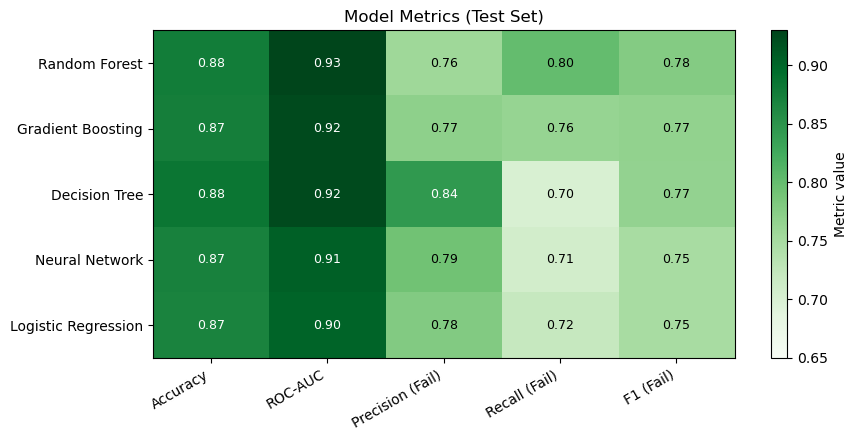

In [30]:
### CODE BY GPT ###

if "final_table" not in globals():
    raise NameError("final_table לא מוגדר. תריצי קודם את התא שמייצר את final_table.")

required_cols = ["Model", "Accuracy", "ROC-AUC", "Precision (Fail)", "Recall (Fail)", "F1 (Fail)"]
missing = [c for c in required_cols if c not in final_table.columns]
if missing:
    raise ValueError(f"final_table חסרות העמודות: {missing}\nבדקי ששמות העמודות תואמים בדיוק.")

metrics = ["Accuracy", "ROC-AUC", "Precision (Fail)", "Recall (Fail)", "F1 (Fail)"]

heat_df = final_table[["Model"] + metrics].set_index("Model")
mat = heat_df.astype(float).values

plt.figure(figsize=(9, 4.5))

im = plt.imshow(
    mat,
    aspect="auto",
    cmap="Greens",
    vmin=0.65,
    vmax=0.93
)

plt.xticks(range(len(metrics)), metrics, rotation=30, ha="right")
plt.yticks(range(len(heat_df.index)), heat_df.index)

text_switch_threshold = 0.82

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        value = mat[i, j]
        text_color = "white" if value >= text_switch_threshold else "black"
        plt.text(
            j, i,
            f"{value:.2f}",
            ha="center",
            va="center",
            fontsize=9,
            color=text_color
        )

plt.title("Model Metrics (Test Set)")
plt.colorbar(im, label="Metric value")

plt.tight_layout()
plt.show()

<div dir="rtl">

### בפרויקט זה, מודלים פשוטים כגון Logistic Regression הגיעו לביצועים דומים למודלים מורכבים יותר, כגון Random Forest ו-Gradient Boosting.
### תוצאה זו מצביעה על signal חזק בדאטה, המאפשר גם למודלים בעלי מבנה פשוט לזהות את הדפוסים המרכזיים.



    
</div>

# 6. Unsupervised Learning


# Feature Engineering


In [31]:
### CODE BY GPT ###

base_cols = ["Risk", "Latitude", "Longitude", "Zip", "Inspection Date", "Violations"]
df_u = df[base_cols].copy()

df_u = df_u.dropna(subset=["Latitude", "Longitude"])

df_u["Inspection Date"] = pd.to_datetime(df_u["Inspection Date"], errors="coerce")
df_u["Inspection Year"] = df_u["Inspection Date"].dt.year
df_u["Inspection Month"] = df_u["Inspection Date"].dt.month
df_u["Inspection Day Of Week"] = df_u["Inspection Date"].dt.dayofweek  # 0=Mon ... 6=Sun

risk_map = {"Risk 1 (High)": 3, "Risk 2 (Medium)": 2, "Risk 3 (Low)": 1}
df_u["Risk_Num"] = df_u["Risk"].map(risk_map)

df_u["Violations"] = df_u["Violations"].fillna("")
df_u["Num_Violations"] = df_u["Violations"].apply(
    lambda s: len([x for x in s.split("|") if x.strip() != ""])
)

X_unsup = df_u[[
    "Risk_Num",
    "Latitude",
    "Longitude",
    "Zip",
    "Inspection Year",
    "Inspection Month",
    "Inspection Day Of Week",
    "Num_Violations"
]].copy()


X_unsup["Zip"] = pd.to_numeric(X_unsup["Zip"], errors="coerce")


X_unsup = X_unsup.dropna().reset_index(drop=True)

print("X_unsup shape:", X_unsup.shape)
X_unsup.head()

X_unsup shape: (212074, 8)


,Risk_Num,Latitude,Longitude,Zip,Inspection Year,Inspection Month,Inspection Day Of Week,Num_Violations
0,3.00,41.89,-87.63,60606.00,2026,1,4,2
1,3.00,41.92,-87.72,60647.00,2025,12,2,3
2,3.00,41.95,-87.65,60657.00,2025,12,2,0
3,3.00,41.93,-87.71,60647.00,2025,12,2,0
4,3.00,41.88,-87.63,60606.00,2025,12,2,0


# Scaling and Sampling


In [32]:
### CODE BY GPT ###

sample_n = 20000
sample_n = min(sample_n, len(X_unsup))

X_sample = X_unsup.sample(n=sample_n, random_state=42).reset_index(drop=True)

scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

print("X_sample shape:", X_sample.shape)
print("X_sample_scaled shape:", X_sample_scaled.shape)


X_sample shape: (20000, 8)
X_sample_scaled shape: (20000, 8)


# PCA Analysis


Explained variance by PC1 and PC2: [0.21017069 0.1862771 ]
Total explained variance: 0.3964477854560423


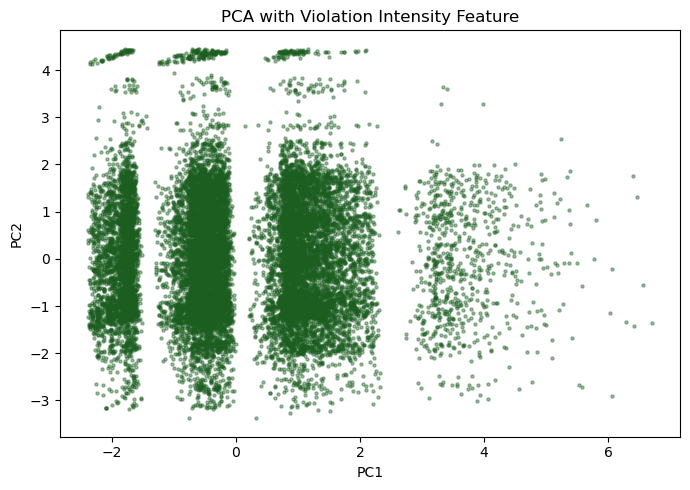

In [33]:
### CODE BY GPT ###

X_enhanced = X_sample.copy()

X_enhanced["Violations_Level"] = pd.cut(
    X_enhanced["Num_Violations"],
    bins=[-1, 0, 3, 10, np.inf],
    labels=[0, 1, 2, 3]
).astype(int)

scaler = StandardScaler()
X_enhanced_scaled = scaler.fit_transform(X_enhanced)

pca = PCA(n_components=2, random_state=42)
X_pca_enhanced = pca.fit_transform(X_enhanced_scaled)

explained_var = pca.explained_variance_ratio_
print("Explained variance by PC1 and PC2:", explained_var)
print("Total explained variance:", explained_var.sum())

plt.figure(figsize=(7, 5))
plt.scatter(
    X_pca_enhanced[:, 0],
    X_pca_enhanced[:, 1],
    s=5,
    alpha=0.4,
    color="#1B5E20"  # ירוק כהה וברור
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA with Violation Intensity Feature")
plt.tight_layout()
plt.show()

<div dir="rtl">

### ניתוח PCA מאפשר לצמצם את הנתונים לשני צירים שניתן להציג בגרף.
### בגרף ניתן לראות מבנה כללי בנתונים, ואף להבחין בחלוקה גסה למספר אזורים או קבוצות לאורך הציר הראשון.
### עם זאת, הקבוצות אינן מופרדות בצורה חדה וקיימת חפיפה ביניהן, ולכן אין חלוקה ברורה לקלאסטרים נפרדים.
### שני הצירים הראשונים מסבירים כ־40% מהשונות בנתונים, מה שמעיד שחלק משמעותי מהמידע נמצא בצירים נוספים שאינם מוצגים בגרף.



    
</div>

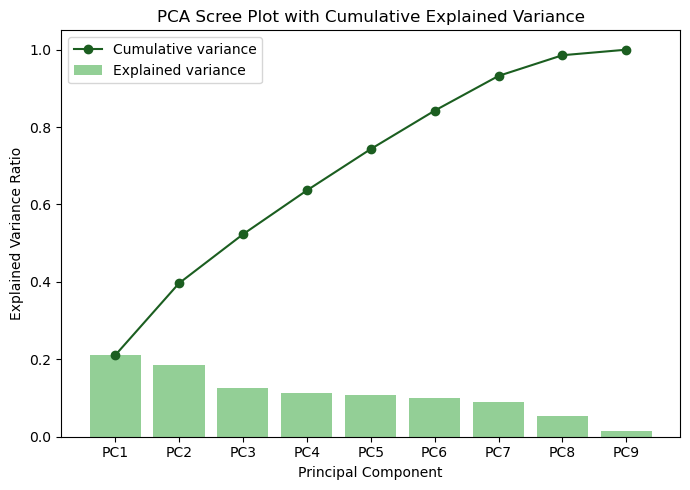

In [34]:
### CODE BY GPT ###

pca_full = PCA(random_state=42)
pca_full.fit(X_enhanced_scaled)

explained_var = pca_full.explained_variance_ratio_
cumulative_var = explained_var. cumsum()

components = range(1, len(explained_var) + 1)
labels = [f"PC{i}" for i in components]

plt.figure(figsize=(7, 5))
plt.bar(
    components,
    explained_var,
    alpha=0.7,
    color="#66BB6A",          
    label="Explained variance"
)
plt.plot(
    components,
    cumulative_var,
    marker="o",
    color="#1B5E20",         
    label="Cumulative variance"
)

plt.xticks(components, labels)  
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot with Cumulative Explained Variance")
plt.legend()
plt.tight_layout()
plt.show()


<div dir="rtl">

### בגרף זה, העמודות מייצגות את שיעור השונות שמוסבר על־ידי כל רכיב עיקרי (PC) בנפרד, והקו מייצג את השונות המצטברת שמוסברת על־ידי הרכיבים העיקריים עד אותו רכיב.




    
</div>

# K-Means Clustering


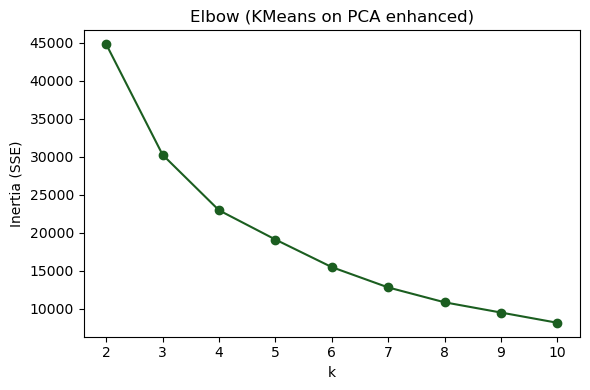

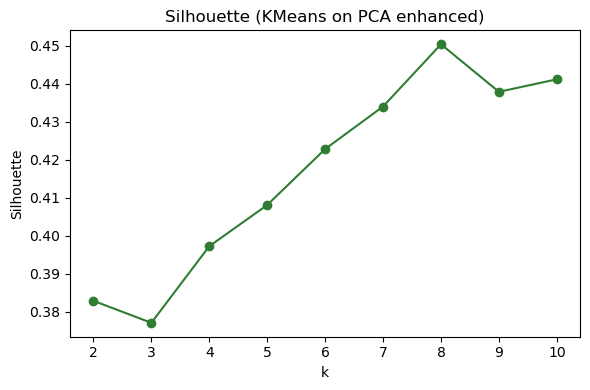

k = 4
Inertia = 22952.88
Silhouette = 0.397


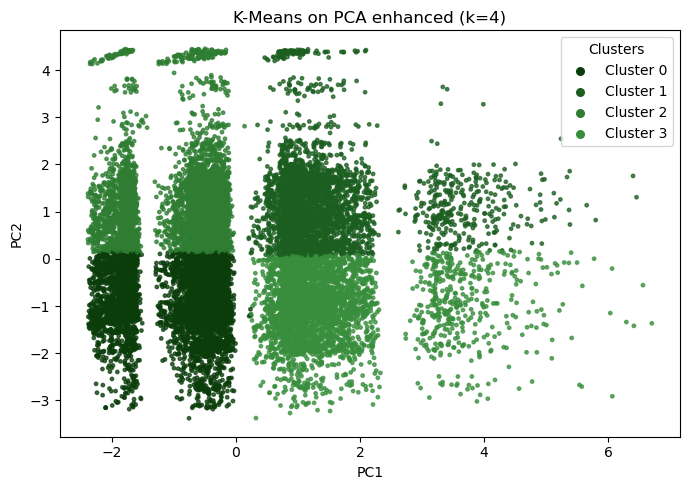

In [35]:
### CODE BY GPT ###

Ks = range(2, 11)
inertias, sils = [], []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca_enhanced)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_pca_enhanced, labels))


plt.figure(figsize=(6,4))
plt.plot(
    list(Ks),
    inertias,
    marker="o",
    color="#1B5E20"
)
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow (KMeans on PCA enhanced)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.plot(
    list(Ks),
    sils,
    marker="o",
    color="#2E7D32"
)
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Silhouette (KMeans on PCA enhanced)")
plt.tight_layout()
plt.show()


k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_enhanced)

print("k =", k)
print("Inertia =", round(kmeans.inertia_, 2))
print("Silhouette =", round(silhouette_score(X_pca_enhanced, clusters), 3))

# צבע אחד קבוע לכל אשכול (4 ירוקים מובחנים, לא בהירים מדי)
cluster_colors = np.array([
    "#0B3D0B",  # Cluster 0
    "#1B5E20",  # Cluster 1
    "#2E7D32",  # Cluster 2
    "#388E3C"   # Cluster 3
])

plt.figure(figsize=(7,5))
plt.scatter(
    X_pca_enhanced[:, 0],
    X_pca_enhanced[:, 1],
    c=cluster_colors[clusters],   # <<< כאן נועל צבע אחיד לכל cluster
    s=6,
    alpha=0.75
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means on PCA enhanced (k={k})")

# legend ידני (כדי שיראה תמיד נכון)
for i in range(k):
    plt.scatter([], [], c=cluster_colors[i], s=30, label=f"Cluster {i}")
plt.legend(title="Clusters", loc="best")

plt.tight_layout()
plt.show()


<div dir="rtl">

### תוצאות אלגוריתם K-Means מצביעות על חלוקה של הנתונים לארבעה אשכולות מובחנים, עם הפרדה סבירה ביניהם כפי שנצפה במרחב ה־PCA.
### מדדי Elbow ו-Silhouette תומכים בבחירה זו ומעידים על איזון בין איכות האשכולות לפשטות המודל.




    
</div>

# DBSCAN Clustering


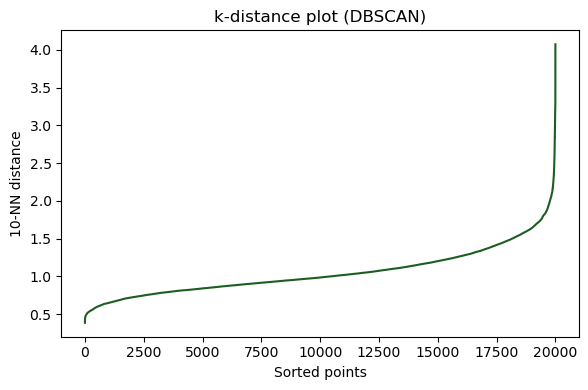

In [36]:
### CODE BY GPT ###

min_samples = 10

nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_enhanced_scaled)

distances, _ = nn.kneighbors(X_enhanced_scaled)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(
    k_distances,
    color="#1B5E20" 
)
plt.xlabel("Sorted points")
plt.ylabel(f"{min_samples}-NN distance")
plt.title("k-distance plot (DBSCAN)")
plt.tight_layout()
plt.show()

In [37]:
### CODE BY GPT ###

dbscan = DBSCAN(eps=1.4, min_samples=10)
db_labels = dbscan.fit_predict(X_enhanced_scaled)

n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = (db_labels == -1).sum()

print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)
print("Noise percentage:", round(n_noise / len(db_labels) * 100, 2), "%")

Number of clusters: 12
Number of noise points: 1017
Noise percentage: 5.08 %


<div dir="rtl">

### DBSCAN זיהה בנתונים תשעה דפוסי התנהגות צפופים, ולצידם כ־5% תצפיות שלא משתלבות באף דפוס נפוץ.
### תצפיות אלו מייצגות מקרים חריגים, כלומר מסעדות עם מאפיינים לא שגרתיים ביחס לרוב הנתונים.



    
</div>

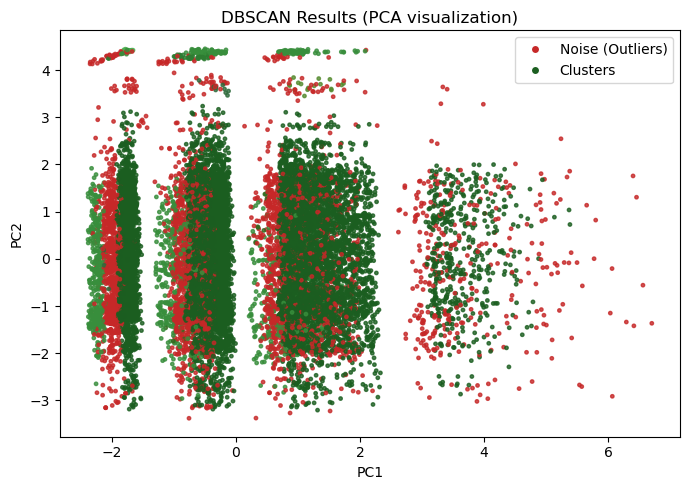

In [38]:
### CODE BY GPT ###

unique_labels = np.unique(db_labels)
n_clusters = len(unique_labels[unique_labels != -1])

# ירוקים לאשכולות
cluster_greens = [
    "#1B5E20",
    "#2E7D32",
    "#388E3C",
    "#4CAF50",
    "#558B2F",
    "#33691E",
    "#43A047",
    "#2F6B3C"
]

cluster_colors = cluster_greens[:n_clusters]

noise_color = "#C62828"  

colors = [noise_color] + cluster_colors
cmap = ListedColormap(colors)


mapped_labels = np.where(db_labels == -1, 0, db_labels + 1)

plt.figure(figsize=(7,5))
plt.scatter(
    X_pca_enhanced[:, 0],
    X_pca_enhanced[:, 1],
    c=mapped_labels,
    cmap=cmap,
    s=6,
    alpha=0.8
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN Results (PCA visualization)")

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               label='Noise (Outliers)',
               markerfacecolor=noise_color, markersize=6),
    plt.Line2D([0], [0], marker='o', color='w',
               label='Clusters',
               markerfacecolor=cluster_colors[0], markersize=6)
]

plt.legend(handles=legend_elements, loc="best")

plt.tight_layout()
plt.show()


<div dir="rtl">

### הגרף מציג את תוצאות אלגוריתם DBSCAN במרחב הנתונים, כאשר ההמחשה הוויזואלית מתבצעת לאחר הקרנה באמצעות PCA. אזורים צפופים (אשכולות) מוצגים בגווני ירוק, ואילו נקודות חריגות (Noise) מסומנות באדום. ניתן לראות כי רוב הנתונים מתארגנים לאשכולות ברורים, בעוד שחלק קטן מהנקודות מזוהה כחריג, בעיקר בשולי ההתפלגות.

    
</div>